In [ ]:
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [1]:
! python --version

Python 3.8.20


In [2]:
! pip install POT

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
! pip install --no-cache-dir --force-reinstall scikit-misc

In [7]:
! pip install GraphST

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [38]:
! pip install SpatialDE

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for NaiveDE: filename=NaiveDE-1.2.0-py3-none-any.whl size=5705 sha256=17f54222b91f04447a03eac1d240964efd278687c7d14b97785415fee0c063ca
  Stored in directory: C:\Users\hyl01\AppData\Local\Temp\pip-ephem-wheel-cache-jln1r3sx\wheels\01\34\53\eff6dafc79c8f34e98fce9705fbcbc458461172e53adb65d16
Successfully built NaiveDE


In [1]:
!conda info --envs


# conda environments:
#
base                   D:\Anaconda
GraphSTenv           * D:\Anaconda\envs\GraphSTenv
myenv                  D:\Anaconda\envs\myenv



In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp

In [2]:
import torch
import numpy as np
import scanpy as sc
import anndata
import rpy2
import pandas as pd
import scipy
import sklearn
import tqdm
import matplotlib
import matplotlib.pyplot as plt

print("PyTorch version:", torch.__version__)
print(torch.__file__)
print("NumPy version:", np.__version__)
print("Scanpy version:", sc.__version__)
print("AnnData version:", anndata.__version__)
print("rpy2 version:", rpy2.__version__)
print("Pandas version:", pd.__version__)
print("SciPy version:", scipy.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("TQDM version:", tqdm.__version__)
print("Matplotlib version:", matplotlib.__version__)


PyTorch version: 2.4.1+cu121
d:\Anaconda\envs\GraphSTenv\lib\site-packages\torch\__init__.py
NumPy version: 1.24.4
Scanpy version: 1.9.1
AnnData version: 0.8.0
rpy2 version: 3.4.1
Pandas version: 1.4.2
SciPy version: 1.8.1
Scikit-learn version: 1.1.1
TQDM version: 4.64.0
Matplotlib version: 3.4.2


In [3]:
from GraphST import GraphST
from GraphST.GraphST_NoHVG import GraphST_NoHVG  # 修改导入方式
from GraphST.GraphST_SVG import GraphST_SVG

In [4]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())

CUDA available: True
CUDA device count: 1


In [5]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = 'D:/R/R-4.3.3'

In [7]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import homogeneity_score, completeness_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.neighbors import NearestNeighbors

def calculate_chaos_score(adata, pred_key='domain', spatial_key='spatial'):
    """计算标准化的CHAOS分数，值越小越好"""
    # 获取空间坐标和聚类标签
    coords = adata.obsm[spatial_key]
    labels = adata.obs[pred_key].values
    
    # 标准化坐标
    coords_normalized = (coords - coords.mean(axis=0)) / coords.std(axis=0)
    
    # 计算标准化后的距离矩阵
    dist_matrix = squareform(pdist(coords_normalized))
    
    # 计算全局平均距离作为参考
    global_mean_dist = np.mean(dist_matrix[np.triu_indices_from(dist_matrix, k=1)])
    
    chaos_scores = []
    for cluster in np.unique(labels):
        mask = labels == cluster
        if np.sum(mask) < 2:  # 跳过只有一个细胞的聚类
            continue
            
        cluster_dists = dist_matrix[mask][:, mask]
        cluster_mean_dist = np.mean(cluster_dists[np.triu_indices_from(cluster_dists, k=1)])
        relative_chaos = cluster_mean_dist / global_mean_dist
        chaos_scores.append(relative_chaos)
    
    return np.mean(chaos_scores)

def calculate_pattern_score(adata, pred_key='domain', spatial_key='spatial', n_neighbors=6):
    """计算Pattern Score，值越大越好"""
    # 获取空间坐标和聚类标签
    coords = adata.obsm[spatial_key]
    labels = adata.obs[pred_key].values
    
    # 找到每个细胞的最近邻
    nbrs = NearestNeighbors(n_neighbors=n_neighbors+1).fit(coords)
    distances, indices = nbrs.kneighbors(coords)
    
    # 计算每个细胞邻居的标签一致性
    pattern_scores = []
    for i in range(len(labels)):
        center_label = labels[i]
        neighbor_labels = labels[indices[i][1:]]  # 排除自身
        consistency = np.mean(neighbor_labels == center_label)
        pattern_scores.append(consistency)
    
    return np.mean(pattern_scores)

def calculate_spatial_asw(adata, pred_key='domain', spatial_key='spatial'):
    """计算空间ASW分数，值越大越好"""
    # 获取空间坐标和聚类标签
    coords = adata.obsm[spatial_key]
    labels = adata.obs[pred_key].values
    
    # 标准化坐标
    coords_normalized = (coords - coords.mean(axis=0)) / coords.std(axis=0)
    
    # 计算完整的距离矩阵
    dist_matrix = squareform(pdist(coords_normalized))
    
    # 计算每个细胞的SW
    sws = []
    for i in range(len(labels)):
        current_label = labels[i]
        
        # 计算a: 同一类内的平均距离
        same_cluster_mask = (labels == current_label)
        same_cluster_mask[i] = False  # 排除自身
        if np.sum(same_cluster_mask) > 0:
            a = np.mean(dist_matrix[i, same_cluster_mask])
        else:
            continue
        
        # 计算b: 最近邻类的平均距离
        other_cluster_distances = []
        for label in np.unique(labels):
            if label != current_label:
                other_cluster_mask = (labels == label)
                if np.sum(other_cluster_mask) > 0:
                    mean_dist = np.mean(dist_matrix[i, other_cluster_mask])
                    other_cluster_distances.append(mean_dist)
        
        if len(other_cluster_distances) > 0:
            b = min(other_cluster_distances)
        else:
            continue
        
        sw = (b - a) / max(a, b)
        sws.append(sw)
    
    # 计算ASW并重新缩放到0-1范围
    asw = np.mean(sws)
    asw_rescaled = (asw + 1) / 2
    
    return asw_rescaled

def evaluate_graphst_results(adata, pred_key='domain', truth_key='annotation', spatial_key='spatial'):
    """评估GraphST聚类结果的综合函数"""
    # 获取预测标签和真实标签
    pred_labels = adata.obs[pred_key]
    true_labels = adata.obs[truth_key]
    
    # 计算基本指标
    hom = homogeneity_score(true_labels, pred_labels)
    com = completeness_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    
    # 计算空间相关指标
    chaos = calculate_chaos_score(adata, pred_key, spatial_key)
    pas = calculate_pattern_score(adata, pred_key, spatial_key)
    asw = calculate_spatial_asw(adata, pred_key, spatial_key)
    
    # 打印所有评估指标
    print("\n=== GraphST Clustering Evaluation ===")
    print(f"Normalized Mutual Information (NMI) = {nmi:.4f}")
    print(f"Homogeneity Score (HOM) = {hom:.4f}")
    print(f"Completeness Score (COM) = {com:.4f}")
    print(f"Spatial ASW Score = {asw:.4f} (越大越好)")
    print(f"Chaotic Score (CHAOS) = {chaos:.4f} (越小越好)")
    print(f"Pattern Score (PAS) = {pas:.4f} (越大越好)")
    print(f"Adjusted Rand Index (ARI) = {ari:.4f}")
    
    # 返回所有指标的字典
    return {
        'NMI': nmi,
        'HOM': hom,
        'COM': com,
        'ASW': asw,
        'CHAOS': chaos,
        'PAS': pas,
        'ARI': ari
    }

# 151673

In [8]:
# the number of clusters
n_clusters = 7

In [9]:
dataset = '151673'

In [10]:
file_fold = './151673'  # 使用相对路径
adata = sc.read_visium(file_fold, count_file='expression_matrix.h5', load_images=True)
adata.var_names_make_unique()

d:\Anaconda\envs\GraphSTenv\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
adata

AnnData object with n_obs × n_vars = 4992 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [12]:
spatial = pd.read_csv(file_fold + '/spatial/tissue_positions_list.csv', sep=",", header=None, na_filter=False, index_col=0)
print("Spatial coordinates shape:", spatial.shape)
print("First few rows of spatial coordinates:")
print(spatial.head())

Spatial coordinates shape: (4992, 5)
First few rows of spatial coordinates:
                    1  2  3     4     5
0                                      
ACGCCTGACACGCGCT-1  0  0  0  2427  2811
TACCGATCCAACACTT-1  0  1  1  2547  2879
ATTAAAGCGGACGAGC-1  0  0  2  2428  2949
GATAAGGGACGATTAG-1  0  1  3  2548  3017
GTGCAAATCACCAATA-1  0  0  4  2429  3086


In [13]:
# 确保坐标列正确赋值
adata.obs["x1"] = spatial[1]
adata.obs["x2"] = spatial[2]
adata.obs["x3"] = spatial[3]
adata.obs["x4"] = spatial[4]
adata.obs["x5"] = spatial[5]

# 打印坐标范围
print("\nCoordinate ranges:")
print("x4 (x_pixel) range:", adata.obs["x4"].min(), adata.obs["x4"].max())
print("x5 (y_pixel) range:", adata.obs["x5"].min(), adata.obs["x5"].max())

# 使用正确的像素坐标列
adata.obs["x_pixel"] = adata.obs["x4"]  # 使用x4作为x坐标（实际像素坐标）
adata.obs["y_pixel"] = adata.obs["x5"]  # 使用x5作为y坐标（实际像素坐标）
print("Spatial coordinates processed!")

# 添加预处理步骤，参考SpaGCN教程
print("Preprocessing data...")
sc.pp.normalize_per_cell(adata, min_counts=0)
sc.pp.log1p(adata)
print("Preprocessing completed!")


Coordinate ranges:
x4 (x_pixel) range: 2427 11715
x5 (y_pixel) range: 2745 11555
Spatial coordinates processed!
Preprocessing data...
Preprocessing completed!


In [74]:
model = GraphST.GraphST(adata, random_seed=3, device=device)
adata = model.train()

d:\Anaconda\envs\GraphSTenv\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Begin to train ST data...


100%|██████████| 600/600 [00:12<00:00, 46.34it/s]

Optimization finished for ST data!


In [14]:
# 3. 运行不带HVG筛选的GraphST
print("\nRunning GraphST without HVG filtering...")
model = GraphST_NoHVG(adata, random_seed=3, device=device)
adata = model.train()


Running GraphST without HVG filtering...
Begin to train ST data...


100%|██████████| 600/600 [01:48<00:00,  5.55it/s]


Optimization finished for ST data!


In [14]:
model = GraphST_SVG(adata, random_seed=3, device=device)
adata = model.train()

Identifying variable genes using scanpy...


d:\Anaconda\envs\GraphSTenv\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Number of identified variable genes: 3000
Begin to train ST data...


100%|██████████| 600/600 [00:13<00:00, 45.90it/s]

Optimization finished for ST data!


In [15]:
# set radius to specify the number of neighbors considered during refinement
radius = 50

tool = 'mclust' # mclust, leiden, and louvain

# clustering
from GraphST.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [16]:
df_meta = pd.read_csv(file_fold + '/151673_layer_annotations.csv')
print(f"Layer annotations shape: {df_meta.shape}")
print(f"AnnData shape: {adata.shape}")

Layer annotations shape: (3611, 2)
AnnData shape: (4992, 33538)


In [17]:
# 检查元数据和数据的索引
meta_index = df_meta['barcode'].tolist()
adata_index = adata.obs.index.tolist()

# 计算重叠部分
common_spots = set(meta_index).intersection(set(adata_index))
print(f"Common spots between layer annotations and data: {len(common_spots)}")

# 根据元数据索引筛选数据
if len(meta_index) != len(adata_index):
    print("Filtering data to match layer annotations...")
    adata = adata[adata.obs.index.isin(meta_index)]
    print(f"After filtering, AnnData shape: {adata.shape}")

# 确保元数据和数据索引完全对齐
df_meta = df_meta.set_index('barcode')
df_meta = df_meta.loc[adata.obs.index]

# 赋值地面真值
adata.obs['ground_truth'] = df_meta['layer'].values

# 过滤掉NA节点
adata = adata[~pd.isnull(adata.obs['ground_truth'])]
print(f"After filtering NA, AnnData shape: {adata.shape}")

evaluate_graphst_results(adata, pred_key='domain', truth_key='ground_truth', spatial_key='spatial')

Common spots between layer annotations and data: 3611
Filtering data to match layer annotations...
After filtering, AnnData shape: (3611, 33538)


C:\Users\hyl01\AppData\Local\Temp\ipykernel_34724\1402554964.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['ground_truth'] = df_meta['layer'].values


After filtering NA, AnnData shape: (3611, 33538)

=== GraphST Clustering Evaluation ===
Normalized Mutual Information (NMI) = 0.4494
Homogeneity Score (HOM) = 0.3751
Completeness Score (COM) = 0.5605
Spatial ASW Score = 0.4911 (越大越好)
Chaotic Score (CHAOS) = 0.6840 (越小越好)
Pattern Score (PAS) = 0.9376 (越大越好)
Adjusted Rand Index (ARI) = 0.2425


{'NMI': 0.44940495477591424,
 'HOM': 0.37508527885530474,
 'COM': 0.5604536593823188,
 'ASW': 0.4910967019675672,
 'CHAOS': 0.684014775557791,
 'PAS': 0.9375519246746054,
 'ARI': 0.242472237084969}

d:\Anaconda\envs\GraphSTenv\lib\site-packages\anndata\_core\anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
d:\Anaconda\envs\GraphSTenv\lib\site-packages\anndata\_core\anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


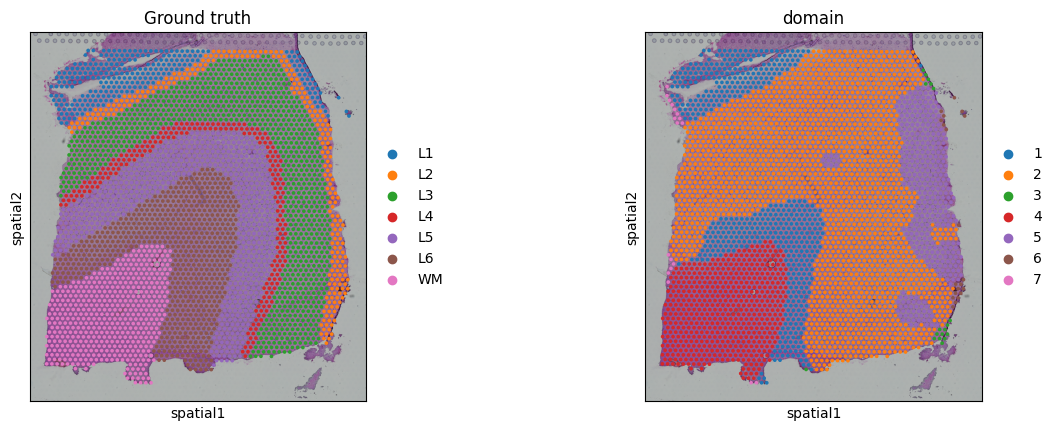

In [18]:
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              color=["ground_truth", "domain"],
              title=["Ground truth", ],
              show=True)

d:\Anaconda\envs\GraphSTenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<AxesSubplot:title={'center':'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

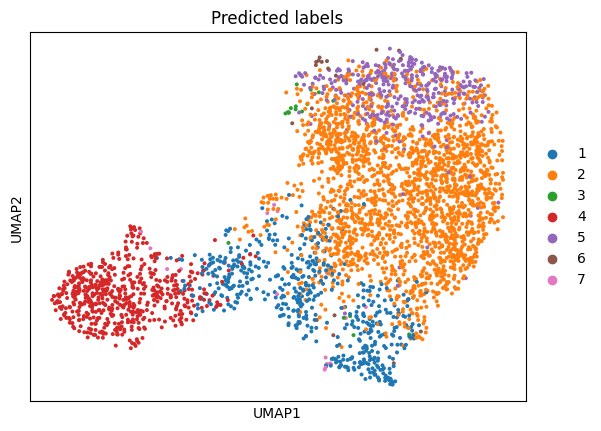

In [19]:
# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=False)

# 151508

In [68]:
# the number of clusters
n_clusters = 7

In [109]:
dataset = '151508'
file_fold = './151508'  # 使用相对路径
adata = sc.read_visium(file_fold, count_file='151508_filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()
adata

d:\Anaconda\envs\GraphSTenv\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4384 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [110]:
spatial = pd.read_csv(file_fold + '/spatial/tissue_positions_list.csv', sep=",", header=None, na_filter=False, index_col=0)
print("Spatial coordinates shape:", spatial.shape)
print("First few rows of spatial coordinates:")
print(spatial.head())

Spatial coordinates shape: (4992, 5)
First few rows of spatial coordinates:
                    1  2  3     4     5
0                                      
ACGCCTGACACGCGCT-1  0  0  0  2575  2169
TACCGATCCAACACTT-1  0  1  1  2695  2237
ATTAAAGCGGACGAGC-1  0  0  2  2576  2306
GATAAGGGACGATTAG-1  0  1  3  2696  2375
GTGCAAATCACCAATA-1  0  0  4  2576  2444


In [111]:
# 确保坐标列正确赋值
adata.obs["x1"] = spatial[1]
adata.obs["x2"] = spatial[2]
adata.obs["x3"] = spatial[3]
adata.obs["x4"] = spatial[4]
adata.obs["x5"] = spatial[5]

# 打印坐标范围
print("\nCoordinate ranges:")
print("x4 (x_pixel) range:", adata.obs["x4"].min(), adata.obs["x4"].max())
print("x5 (y_pixel) range:", adata.obs["x5"].min(), adata.obs["x5"].max())

# 使用正确的像素坐标列
adata.obs["x_pixel"] = adata.obs["x4"]  # 使用x4作为x坐标（实际像素坐标）
adata.obs["y_pixel"] = adata.obs["x5"]  # 使用x5作为y坐标（实际像素坐标）
print("Spatial coordinates processed!")

# 添加预处理步骤，参考SpaGCN教程
print("Preprocessing data...")
sc.pp.normalize_per_cell(adata, min_counts=0)
sc.pp.log1p(adata)
print("Preprocessing completed!")


Coordinate ranges:
x4 (x_pixel) range: 2579 11821
x5 (y_pixel) range: 2152 10910
Spatial coordinates processed!
Preprocessing data...
Preprocessing completed!


In [112]:
model = GraphST.GraphST(adata, random_seed=3, device=device)
adata = model.train()

d:\Anaconda\envs\GraphSTenv\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Begin to train ST data...


100%|██████████| 600/600 [00:10<00:00, 55.66it/s]

Optimization finished for ST data!


In [113]:
# set radius to specify the number of neighbors considered during refinement
radius = 50

tool = 'mclust' # mclust, leiden, and louvain

# clustering
from GraphST.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

fitting ...
  |======================================================================| 100%


In [114]:
df_meta = pd.read_csv(file_fold + '/151508_layer_annotations.csv')
print(f"Layer annotations shape: {df_meta.shape}")
print(f"AnnData shape: {adata.shape}")

Layer annotations shape: (4381, 2)
AnnData shape: (4384, 33538)


In [115]:
# 检查元数据和数据的索引
meta_index = df_meta['barcode'].tolist()
adata_index = adata.obs.index.tolist()

# 计算重叠部分
common_spots = set(meta_index).intersection(set(adata_index))
print(f"Common spots between layer annotations and data: {len(common_spots)}")

# 根据元数据索引筛选数据
if len(meta_index) != len(adata_index):
    print("Filtering data to match layer annotations...")
    adata = adata[adata.obs.index.isin(meta_index)]
    print(f"After filtering, AnnData shape: {adata.shape}")

# 确保元数据和数据索引完全对齐
df_meta = df_meta.set_index('barcode')
df_meta = df_meta.loc[adata.obs.index]

# 赋值地面真值
adata.obs['ground_truth'] = df_meta['layer'].values

# 过滤掉NA节点
adata = adata[~pd.isnull(adata.obs['ground_truth'])]
print(f"After filtering NA, AnnData shape: {adata.shape}")

evaluate_graphst_results(adata, pred_key='domain', truth_key='ground_truth', spatial_key='spatial')

Common spots between layer annotations and data: 4381
Filtering data to match layer annotations...
After filtering, AnnData shape: (4381, 33538)


C:\Users\hyl01\AppData\Local\Temp\ipykernel_20844\1402554964.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['ground_truth'] = df_meta['layer'].values


After filtering NA, AnnData shape: (4381, 33538)

=== GraphST Clustering Evaluation ===
Normalized Mutual Information (NMI) = 0.4642
Homogeneity Score (HOM) = 0.4562
Completeness Score (COM) = 0.4726
Spatial ASW Score = 0.5284 (越大越好)
Chaotic Score (CHAOS) = 0.5142 (越小越好)
Pattern Score (PAS) = 0.9410 (越大越好)
Adjusted Rand Index (ARI) = 0.2230


{'NMI': 0.4642330086225574,
 'HOM': 0.45619554019561037,
 'COM': 0.47255877219705905,
 'ASW': 0.5283546518031427,
 'CHAOS': 0.5142484262259724,
 'PAS': 0.9409571635090922,
 'ARI': 0.22301084357090822}

d:\Anaconda\envs\GraphSTenv\lib\site-packages\anndata\_core\anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
d:\Anaconda\envs\GraphSTenv\lib\site-packages\anndata\_core\anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


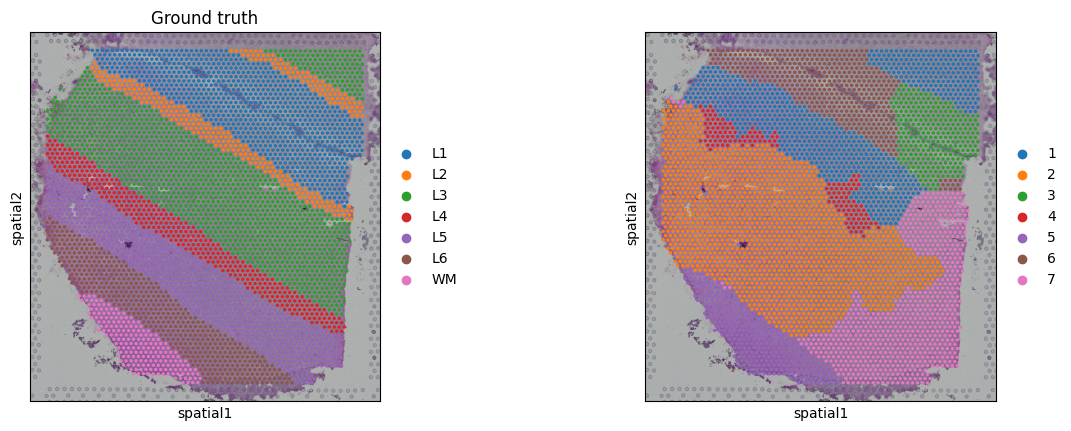

In [116]:
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              color=["ground_truth", "domain"],
              title=["Ground truth", ""],
              show=True)

<AxesSubplot:title={'center':'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

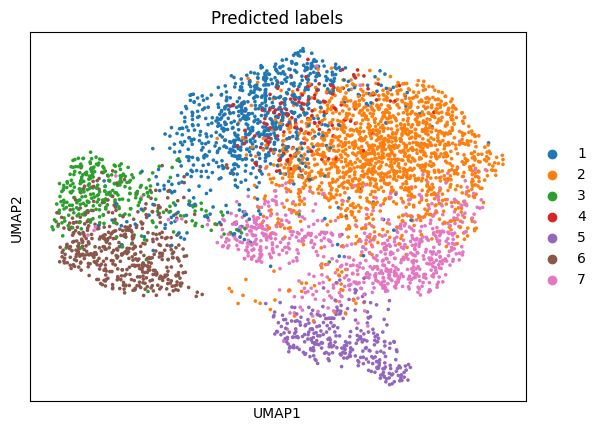

In [117]:
# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=False)

# 151510

d:\Anaconda\envs\GraphSTenv\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Spatial coordinates shape: (4992, 5)
First few rows of spatial coordinates:
                    1  2  3     4     5
0                                      
ACGCCTGACACGCGCT-1  0  0  0  2629  2222
TACCGATCCAACACTT-1  0  1  1  2750  2290
ATTAAAGCGGACGAGC-1  0  0  2  2630  2360
GATAAGGGACGATTAG-1  0  1  3  2751  2429
GTGCAAATCACCAATA-1  0  0  4  2631  2499

Coordinate ranges:
x4 (x_pixel) range: 2649 11968
x5 (y_pixel) range: 2163 10999
Spatial coordinates processed!
Preprocessing data...
Preprocessing completed!


d:\Anaconda\envs\GraphSTenv\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Begin to train ST data...


100%|██████████| 600/600 [00:11<00:00, 50.93it/s]


Optimization finished for ST data!
fitting ...
  |======================================================================| 100%
Layer annotations shape: (4595, 2)
AnnData shape: (4634, 33538)
Common spots between layer annotations and data: 4595
Filtering data to match layer annotations...
After filtering, AnnData shape: (4595, 33538)


C:\Users\hyl01\AppData\Local\Temp\ipykernel_20844\4218747730.py:77: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['ground_truth'] = df_meta['layer'].values


After filtering NA, AnnData shape: (4595, 33538)

=== GraphST Clustering Evaluation ===
Normalized Mutual Information (NMI) = 0.5501
Homogeneity Score (HOM) = 0.4882
Completeness Score (COM) = 0.6300
Spatial ASW Score = 0.3879 (越大越好)
Chaotic Score (CHAOS) = 0.5693 (越小越好)
Pattern Score (PAS) = 0.9383 (越大越好)
Adjusted Rand Index (ARI) = 0.4295


d:\Anaconda\envs\GraphSTenv\lib\site-packages\anndata\_core\anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
d:\Anaconda\envs\GraphSTenv\lib\site-packages\anndata\_core\anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


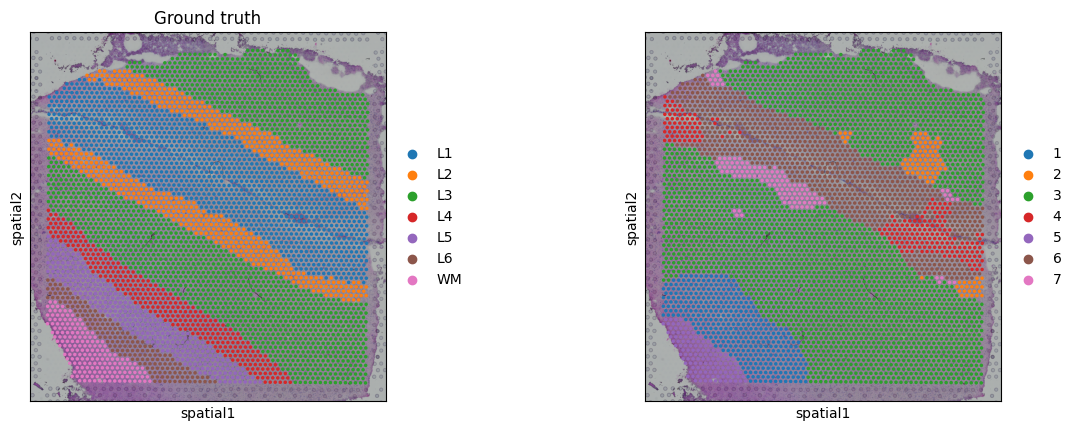

<AxesSubplot:title={'center':'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

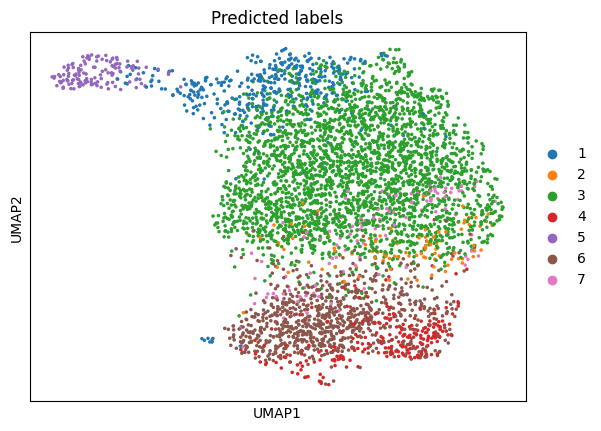

In [118]:
# the number of clusters
n_clusters = 7

dataset = '151510'
file_fold = './151510'  # 使用相对路径
adata = sc.read_visium(file_fold, count_file='151510_filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()
adata

spatial = pd.read_csv(file_fold + '/spatial/tissue_positions_list.csv', sep=",", header=None, na_filter=False, index_col=0)
print("Spatial coordinates shape:", spatial.shape)
print("First few rows of spatial coordinates:")
print(spatial.head())

# 确保坐标列正确赋值
adata.obs["x1"] = spatial[1]
adata.obs["x2"] = spatial[2]
adata.obs["x3"] = spatial[3]
adata.obs["x4"] = spatial[4]
adata.obs["x5"] = spatial[5]

# 打印坐标范围
print("\nCoordinate ranges:")
print("x4 (x_pixel) range:", adata.obs["x4"].min(), adata.obs["x4"].max())
print("x5 (y_pixel) range:", adata.obs["x5"].min(), adata.obs["x5"].max())

# 使用正确的像素坐标列
adata.obs["x_pixel"] = adata.obs["x4"]  # 使用x4作为x坐标（实际像素坐标）
adata.obs["y_pixel"] = adata.obs["x5"]  # 使用x5作为y坐标（实际像素坐标）
print("Spatial coordinates processed!")

# 添加预处理步骤，参考SpaGCN教程
print("Preprocessing data...")
sc.pp.normalize_per_cell(adata, min_counts=0)
sc.pp.log1p(adata)
print("Preprocessing completed!")

model = GraphST.GraphST(adata, random_seed=3, device=device)
adata = model.train()

# set radius to specify the number of neighbors considered during refinement
radius = 50

tool = 'mclust' # mclust, leiden, and louvain

# clustering
from GraphST.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

df_meta = pd.read_csv(file_fold + '/151510_layer_annotations.csv')
print(f"Layer annotations shape: {df_meta.shape}")
print(f"AnnData shape: {adata.shape}")

# 检查元数据和数据的索引
meta_index = df_meta['barcode'].tolist()
adata_index = adata.obs.index.tolist()

# 计算重叠部分
common_spots = set(meta_index).intersection(set(adata_index))
print(f"Common spots between layer annotations and data: {len(common_spots)}")

# 根据元数据索引筛选数据
if len(meta_index) != len(adata_index):
    print("Filtering data to match layer annotations...")
    adata = adata[adata.obs.index.isin(meta_index)]
    print(f"After filtering, AnnData shape: {adata.shape}")

# 确保元数据和数据索引完全对齐
df_meta = df_meta.set_index('barcode')
df_meta = df_meta.loc[adata.obs.index]

# 赋值地面真值
adata.obs['ground_truth'] = df_meta['layer'].values

# 过滤掉NA节点
adata = adata[~pd.isnull(adata.obs['ground_truth'])]
print(f"After filtering NA, AnnData shape: {adata.shape}")

evaluate_graphst_results(adata, pred_key='domain', truth_key='ground_truth', spatial_key='spatial')

# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              color=["ground_truth", "domain"],
              title=["Ground truth", ""],
              show=True)

# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=False)

# 151674

d:\Anaconda\envs\GraphSTenv\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Spatial coordinates shape: (4992, 5)
First few rows of spatial coordinates:
                    1  2  3     4     5
0                                      
ACGCCTGACACGCGCT-1  0  0  0  2492  2756
TACCGATCCAACACTT-1  0  1  1  2612  2824
ATTAAAGCGGACGAGC-1  0  0  2  2493  2894
GATAAGGGACGATTAG-1  0  1  3  2613  2962
GTGCAAATCACCAATA-1  0  0  4  2494  3031

Coordinate ranges:
x4 (x_pixel) range: 2505 11769
x5 (y_pixel) range: 2967 10934
Spatial coordinates processed!
Preprocessing data...
Preprocessing completed!


d:\Anaconda\envs\GraphSTenv\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Begin to train ST data...


100%|██████████| 600/600 [00:08<00:00, 74.82it/s]


Optimization finished for ST data!
fitting ...
  |======================================================================| 100%
Layer annotations shape: (3635, 2)
AnnData shape: (3673, 33538)
Common spots between layer annotations and data: 3635
Filtering data to match layer annotations...
After filtering, AnnData shape: (3635, 33538)
After filtering NA, AnnData shape: (3635, 33538)


C:\Users\hyl01\AppData\Local\Temp\ipykernel_20844\4261062050.py:77: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['ground_truth'] = df_meta['layer'].values



=== GraphST Clustering Evaluation ===
Normalized Mutual Information (NMI) = 0.4825
Homogeneity Score (HOM) = 0.4676
Completeness Score (COM) = 0.4984
Spatial ASW Score = 0.6028 (越大越好)
Chaotic Score (CHAOS) = 0.5043 (越小越好)
Pattern Score (PAS) = 0.9465 (越大越好)
Adjusted Rand Index (ARI) = 0.3609


d:\Anaconda\envs\GraphSTenv\lib\site-packages\anndata\_core\anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
d:\Anaconda\envs\GraphSTenv\lib\site-packages\anndata\_core\anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


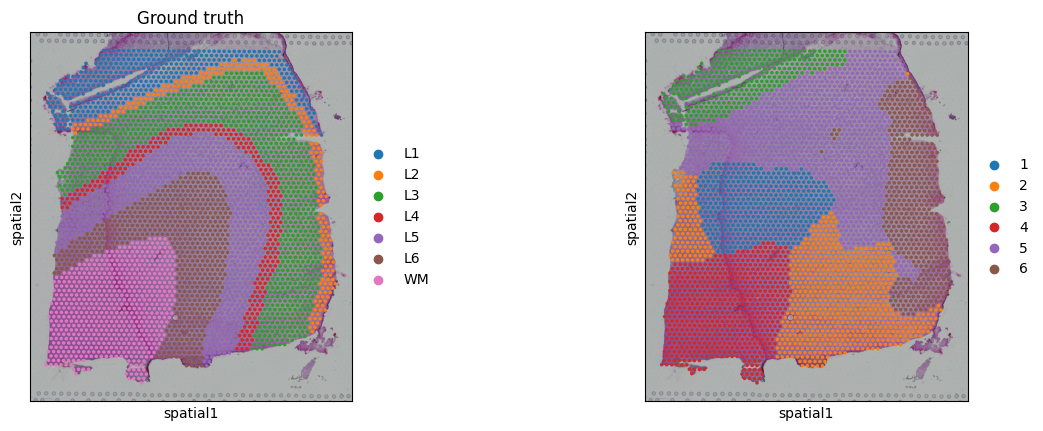

<AxesSubplot:title={'center':'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

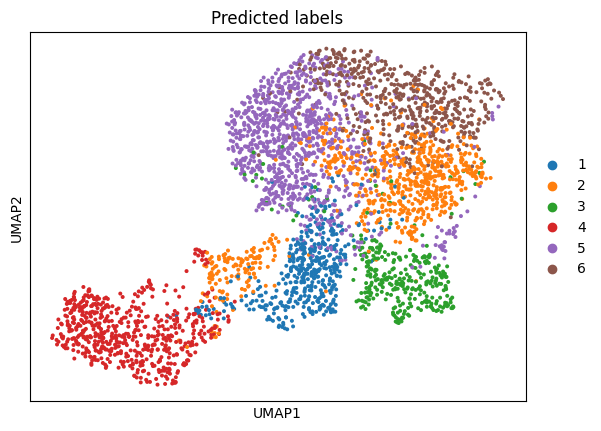

In [119]:
# the number of clusters
n_clusters = 7

dataset = '151674'
file_fold = './151674'  # 使用相对路径
adata = sc.read_visium(file_fold, count_file='151674_filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()
adata

spatial = pd.read_csv(file_fold + '/spatial/tissue_positions_list.csv', sep=",", header=None, na_filter=False, index_col=0)
print("Spatial coordinates shape:", spatial.shape)
print("First few rows of spatial coordinates:")
print(spatial.head())

# 确保坐标列正确赋值
adata.obs["x1"] = spatial[1]
adata.obs["x2"] = spatial[2]
adata.obs["x3"] = spatial[3]
adata.obs["x4"] = spatial[4]
adata.obs["x5"] = spatial[5]

# 打印坐标范围
print("\nCoordinate ranges:")
print("x4 (x_pixel) range:", adata.obs["x4"].min(), adata.obs["x4"].max())
print("x5 (y_pixel) range:", adata.obs["x5"].min(), adata.obs["x5"].max())

# 使用正确的像素坐标列
adata.obs["x_pixel"] = adata.obs["x4"]  # 使用x4作为x坐标（实际像素坐标）
adata.obs["y_pixel"] = adata.obs["x5"]  # 使用x5作为y坐标（实际像素坐标）
print("Spatial coordinates processed!")

# 添加预处理步骤，参考SpaGCN教程
print("Preprocessing data...")
sc.pp.normalize_per_cell(adata, min_counts=0)
sc.pp.log1p(adata)
print("Preprocessing completed!")

model = GraphST.GraphST(adata, random_seed=3, device=device)
adata = model.train()

# set radius to specify the number of neighbors considered during refinement
radius = 50

tool = 'mclust' # mclust, leiden, and louvain

# clustering
from GraphST.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

df_meta = pd.read_csv(file_fold + '/151674_layer_annotations.csv')
print(f"Layer annotations shape: {df_meta.shape}")
print(f"AnnData shape: {adata.shape}")

# 检查元数据和数据的索引
meta_index = df_meta['barcode'].tolist()
adata_index = adata.obs.index.tolist()

# 计算重叠部分
common_spots = set(meta_index).intersection(set(adata_index))
print(f"Common spots between layer annotations and data: {len(common_spots)}")

# 根据元数据索引筛选数据
if len(meta_index) != len(adata_index):
    print("Filtering data to match layer annotations...")
    adata = adata[adata.obs.index.isin(meta_index)]
    print(f"After filtering, AnnData shape: {adata.shape}")

# 确保元数据和数据索引完全对齐
df_meta = df_meta.set_index('barcode')
df_meta = df_meta.loc[adata.obs.index]

# 赋值地面真值
adata.obs['ground_truth'] = df_meta['layer'].values

# 过滤掉NA节点
adata = adata[~pd.isnull(adata.obs['ground_truth'])]
print(f"After filtering NA, AnnData shape: {adata.shape}")

evaluate_graphst_results(adata, pred_key='domain', truth_key='ground_truth', spatial_key='spatial')

# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              color=["ground_truth", "domain"],
              title=["Ground truth", ""],
              show=True)

# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=False)

# E2S2

In [20]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
from GraphST import GraphST

In [25]:
adata = sc.read_h5ad('./E9.5_E2S2.MOSTA.h5ad')
adata.var_names_make_unique()

In [26]:
# 查看真实标签的类别数
n_clusters = len(adata.obs['annotation'].unique())
print(f"\n真实标签类别数: {n_clusters}")
print("\n各类别的样本数：")
print(adata.obs['annotation'].value_counts())


真实标签类别数: 13

各类别的样本数：
Brain                  636
Heart                  581
Cavity                 489
Mesenchyme             383
Surface ectoderm       371
AGM                    366
Spinal cord            357
Sclerotome             339
Lung primordium        286
Head mesenchyme        196
Liver                  191
Pancreas primordium    114
Notochord               47
Name: annotation, dtype: int64


In [27]:
device = torch.device('cuda:0')  # 如果有GPU，可以改为'cuda:0'

In [28]:
model = GraphST_SVG(adata, random_seed=3, datatype='Stereo', device=device)
adata = model.train()

Identifying variable genes using scanpy...


d:\Anaconda\envs\GraphSTenv\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Number of identified variable genes: 3000
Graph constructed!
Building sparse matrix ...
Begin to train ST data...


100%|██████████| 600/600 [00:08<00:00, 74.64it/s]

Optimization finished for ST data!


In [24]:
# 3. 运行不带HVG筛选的GraphST
print("\nRunning GraphST without HVG filtering...")
model = GraphST_NoHVG(adata, random_seed=3, datatype='Stereo', device=device)
adata = model.train()


Running GraphST without HVG filtering...
Graph constructed!


c:\Users\hyl01\GraphST_project\GraphST_part\GraphST\preprocess.py:151: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:643.)
  return torch.sparse.FloatTensor(indices, values, shape)


Building sparse matrix ...
Begin to train ST data...


100%|██████████| 600/600 [00:38<00:00, 15.78it/s]

Optimization finished for ST data!


In [134]:
model = GraphST.GraphST(adata, 
                        random_seed=0,
                        datatype='Stereo',  # 因为是Stereo-seq数据
                        device=device)

d:\Anaconda\envs\GraphSTenv\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Graph constructed!
Building sparse matrix ...


c:\Users\hyl01\GraphST_project\GraphST_part\GraphST\preprocess.py:150: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:643.)
  return torch.sparse.FloatTensor(indices, values, shape)


In [135]:
# 运行模型
adata = model.train()

Begin to train ST data...


100%|██████████| 600/600 [00:08<00:00, 69.84it/s]

Optimization finished for ST data!


In [29]:
# 使用mclust进行聚类
from GraphST.utils import clustering
clustering(adata, n_clusters, method='mclust')

fitting ...
  |======================================================================| 100%


In [30]:
evaluate_graphst_results(adata)


=== GraphST Clustering Evaluation ===
Normalized Mutual Information (NMI) = 0.5844
Homogeneity Score (HOM) = 0.5666
Completeness Score (COM) = 0.6033
Spatial ASW Score = 0.4342 (越大越好)
Chaotic Score (CHAOS) = 0.5504 (越小越好)
Pattern Score (PAS) = 0.8297 (越大越好)
Adjusted Rand Index (ARI) = 0.3806


{'NMI': 0.5844057909724718,
 'HOM': 0.566635710007338,
 'COM': 0.603326520696787,
 'ASW': 0.43422220612450546,
 'CHAOS': 0.5503765055442297,
 'PAS': 0.8296602387511478,
 'ARI': 0.38061756395103413}

<Figure size 1000x1000 with 0 Axes>

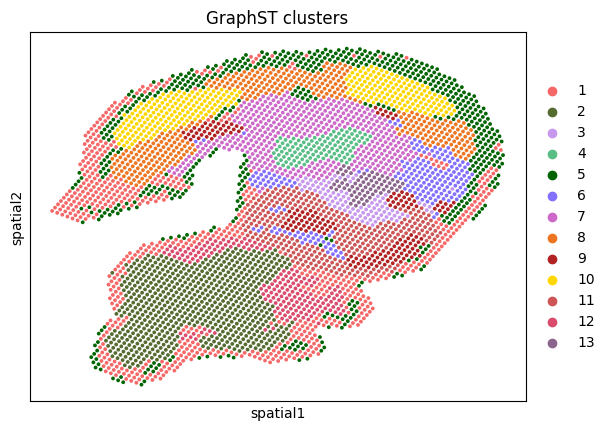

<Figure size 1000x1000 with 0 Axes>

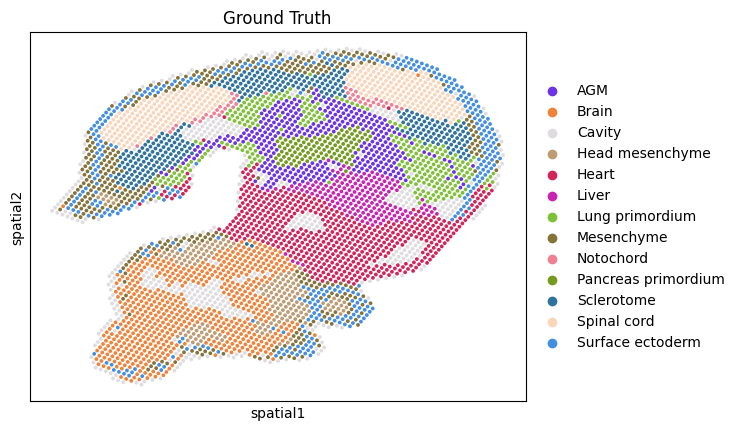

In [27]:
# 可视化
import matplotlib.pyplot as plt

# 设置绘图颜色
plot_color = ["#F56867","#556B2F","#C798EE","#59BE86","#006400","#8470FF",
              "#CD69C9","#EE7621","#B22222","#FFD700","#CD5555","#DB4C6C",
              "#8B658B","#1E90FF","#AF5F3C","#CAFF70", "#F9BD3F","#DAB370",
              "#877F6C","#268785", '#82EF2D', '#B4EEB4']

plt.figure(figsize=(10, 10))
ax = sc.pl.embedding(adata, basis="spatial",
                    color="domain",
                    s=30,
                    palette=plot_color[:n_clusters],
                    title='GraphST clusters')
plt.show()

# 如果想要对比真实标签的分布
plt.figure(figsize=(10, 10))
ax = sc.pl.embedding(adata, basis="spatial",
                    color="annotation",
                    s=30,
                    title='Ground Truth')
plt.show()

# E1S1

In [139]:
adata = sc.read_h5ad('./E9.5_E1S1.MOSTA.h5ad')
adata.var_names_make_unique()
n_clusters = len(adata.obs['annotation'].unique())

model = GraphST.GraphST(adata, 
                        random_seed=0,
                       datatype='Stereo',  # 因为是Stereo-seq数据
                       device=device)

adata = model.train()

clustering(adata, n_clusters, method='mclust')

metrics = evaluate_graphst_results(adata)

d:\Anaconda\envs\GraphSTenv\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Graph constructed!
Building sparse matrix ...
Begin to train ST data...


100%|██████████| 600/600 [00:11<00:00, 53.00it/s]


Optimization finished for ST data!
fitting ...
  |======================================================================| 100%

=== GraphST Clustering Evaluation ===
Normalized Mutual Information (NMI) = 0.5155
Homogeneity Score (HOM) = 0.5401
Completeness Score (COM) = 0.4930
Spatial ASW Score = 0.5448 (越大越好)
Chaotic Score (CHAOS) = 0.4394 (越小越好)
Pattern Score (PAS) = 0.9053 (越大越好)
Adjusted Rand Index (ARI) = 0.2869


<Figure size 1000x1000 with 0 Axes>

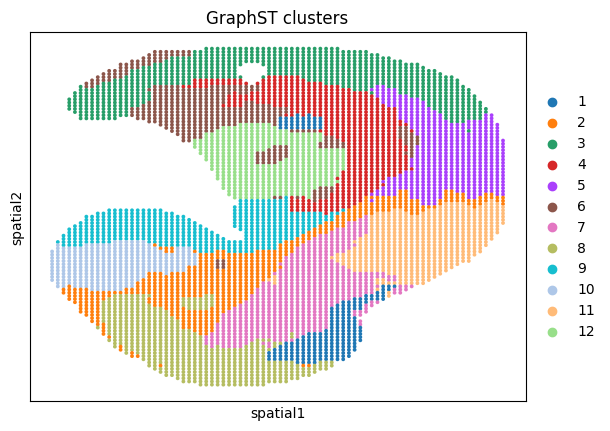

<Figure size 1000x1000 with 0 Axes>

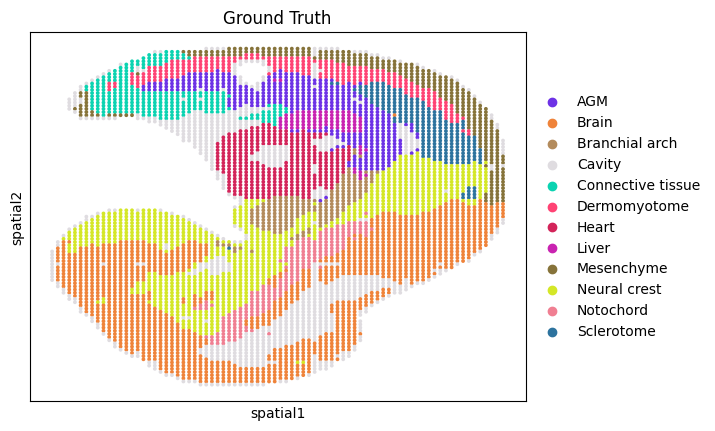

In [63]:
plt.figure(figsize=(10, 10))
ax = sc.pl.embedding(adata, basis="spatial",
                    color="domain",
                    s=30,
                    title='GraphST clusters')
plt.show()

# 如果想要对比真实标签的分布
plt.figure(figsize=(10, 10))
ax = sc.pl.embedding(adata, basis="spatial",
                    color="annotation",
                    s=30,
                    title='Ground Truth')
plt.show()

# E2S3

d:\Anaconda\envs\GraphSTenv\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Graph constructed!
Building sparse matrix ...
Begin to train ST data...


100%|██████████| 600/600 [00:09<00:00, 60.43it/s]


Optimization finished for ST data!
fitting ...
  |======================================================================| 100%

=== GraphST Clustering Evaluation ===
Normalized Mutual Information (NMI) = 0.5805
Homogeneity Score (HOM) = 0.5712
Completeness Score (COM) = 0.5901
Spatial ASW Score = 0.3791 (越大越好)
Chaotic Score (CHAOS) = 0.5418 (越小越好)
Pattern Score (PAS) = 0.8426 (越大越好)
Adjusted Rand Index (ARI) = 0.3812


<Figure size 1000x1000 with 0 Axes>

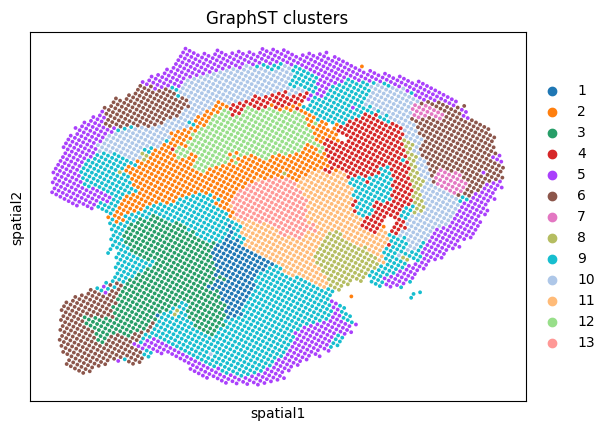

<Figure size 1000x1000 with 0 Axes>

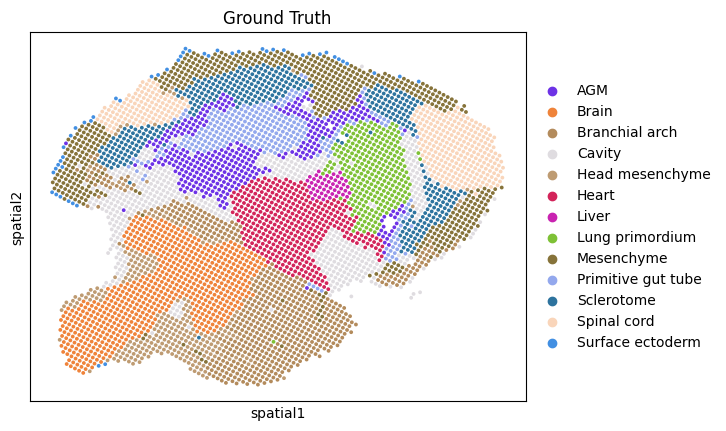

In [140]:
adata = sc.read_h5ad('./E9.5_E2S3.MOSTA.h5ad')
adata.var_names_make_unique()
n_clusters = len(adata.obs['annotation'].unique())

model = GraphST.GraphST(adata, 
                        random_seed=0,
                       datatype='Stereo',  # 因为是Stereo-seq数据
                       device=device)

adata = model.train()

clustering(adata, n_clusters, method='mclust')

metrics = evaluate_graphst_results(adata)

plt.figure(figsize=(10, 10))
ax = sc.pl.embedding(adata, basis="spatial",
                    color="domain",
                    s=30,
                    title='GraphST clusters')
plt.show()

# 如果想要对比真实标签的分布
plt.figure(figsize=(10, 10))
ax = sc.pl.embedding(adata, basis="spatial",
                    color="annotation",
                    s=30,
                    title='Ground Truth')
plt.show()

# E2S4

d:\Anaconda\envs\GraphSTenv\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Graph constructed!
Building sparse matrix ...
Begin to train ST data...


100%|██████████| 600/600 [00:11<00:00, 54.46it/s]


Optimization finished for ST data!
fitting ...
  |======================================================================| 100%

=== GraphST Clustering Evaluation ===
Normalized Mutual Information (NMI) = 0.5549
Homogeneity Score (HOM) = 0.5576
Completeness Score (COM) = 0.5522
Spatial ASW Score = 0.4148 (越大越好)
Chaotic Score (CHAOS) = 0.5594 (越小越好)
Pattern Score (PAS) = 0.8254 (越大越好)
Adjusted Rand Index (ARI) = 0.3361


<Figure size 1000x1000 with 0 Axes>

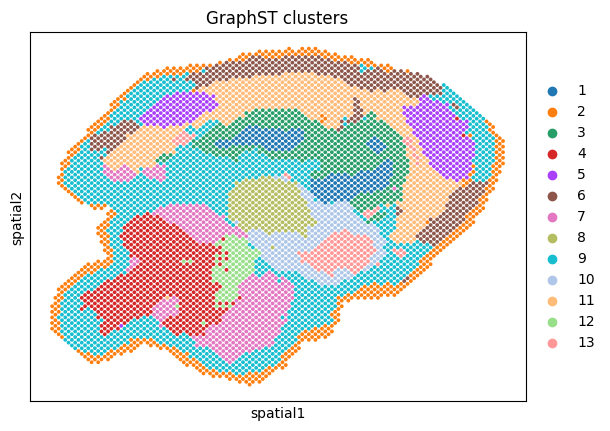

<Figure size 1000x1000 with 0 Axes>

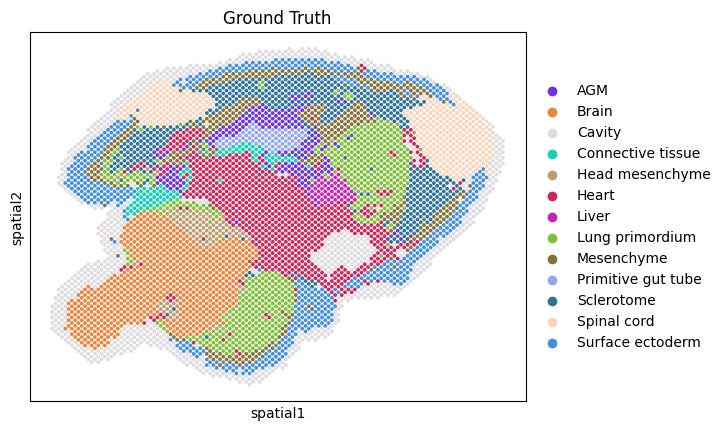

In [141]:
adata = sc.read_h5ad('./E9.5_E2S4.MOSTA.h5ad')
adata.var_names_make_unique()
n_clusters = len(adata.obs['annotation'].unique())

model = GraphST.GraphST(adata, 
                        random_seed=0,
                       datatype='Stereo',  # 因为是Stereo-seq数据
                       device=device)

adata = model.train()

clustering(adata, n_clusters, method='mclust')

metrics = evaluate_graphst_results(adata)

plt.figure(figsize=(10, 10))
ax = sc.pl.embedding(adata, basis="spatial",
                    color="domain",
                    s=30,
                    title='GraphST clusters')
plt.show()

# 如果想要对比真实标签的分布
plt.figure(figsize=(10, 10))
ax = sc.pl.embedding(adata, basis="spatial",
                    color="annotation",
                    s=30,
                    title='Ground Truth')
plt.show()

# osmFISH

In [17]:
!pip install loompy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for loompy: filename=loompy-3.0.8-py3-none-any.whl size=54026 sha256=6f4952eb5ca5c609cf68039afd6df7597992b87595f55212fae14fb9893317df
  Stored in directory: C:\Users\hyl01\AppData\Local\Temp\pip-ephem-wheel-cache-z_45ymao\wheels\44\48\ab\147b17d446df7e31dad83d7eda4e77cfd12840f0894c8e13ff
  Created wheel for numpy-groupies: filename=numpy_groupies-0.9.22-py3-none-any.whl size=25876 sha256=78f0d3727dc73c05e8cc9ed711b8f249c276671f357b23d755a152d9b2095b67
  Stored in directory: C:\Users\hyl01\AppData\Local\Temp\pip-ephem-wheel-cache-z_45ymao\wheels\e7\be\61\60c3bfac3b63cbe691ea4a6a8d9acdeaf2670ed3cd439ecb2a
Successfully built loompy numpy-groupies


In [31]:
import loompy

In [32]:
# 使用相对路径读取文件
try:
    adata = sc.read_loom(os.path.join('..', 'GraphST_part', 'osmFISH_SScortex_mouse_all_cells.loom'))
    print("Data shape:", adata.shape)
    print("\nAvailable annotations:", list(adata.obs.keys()))
    print("\nAvailable embeddings:", list(adata.obsm.keys()) if hasattr(adata, 'obsm') else "No embeddings")
    print("\nLayers:", list(adata.layers.keys()) if hasattr(adata, 'layers') else "No layers")
    
    # 检查是否有空间信息
    if 'X' in adata.obs and 'Y' in adata.obs:
        # 如果空间坐标在obs中，将其移到obsm
        adata.obsm['spatial'] = np.array([adata.obs['X'], adata.obs['Y']]).T
        print("\nSpatial coordinates moved to obsm['spatial']")
    
    print("\nSpatial coordinates available:", 'spatial' in adata.obsm)
    
except Exception as e:
    print("Error reading file:", str(e))
    raise

Data shape: (6471, 33)

Available annotations: ['ClusterID', 'ClusterName', 'Region', 'Total_molecules', 'Valid', 'X', 'Y', '_tSNE_1', '_tSNE_2', 'size_pix', 'size_um2']

Available embeddings: []

Layers: []

Spatial coordinates moved to obsm['spatial']

Spatial coordinates available: True



真实类别分布:
Excluded                           1632
pyramidal L4                        526
Oligodendrocyte Mature              450
Pyramidal L6                        439
Pyramidal L2-3 L5                   318
Endothelial                         252
Pyramidal L2-3                      206
Oligodendrocyte COP                 171
Pyramidal L5                        171
Inhibitory CP                       170
Pyramidal L3-4                      158
Hippocampus                         148
Inhibitory Vip                      142
Inhibitory Crhbp                    134
Astrocyte Mfge8                     131
Oligodendrocyte Precursor cells     128
Oligodendrocyte MF                  121
Ependymal                           112
Pericytes                           106
Endothelial 1                       105
Inhibitory Pthlh                    104
Pyramidal Cpne5                      97
Inhibitory Kcnip2                    92
Inhibitory IC                        91
Astrocyte Gfap                 

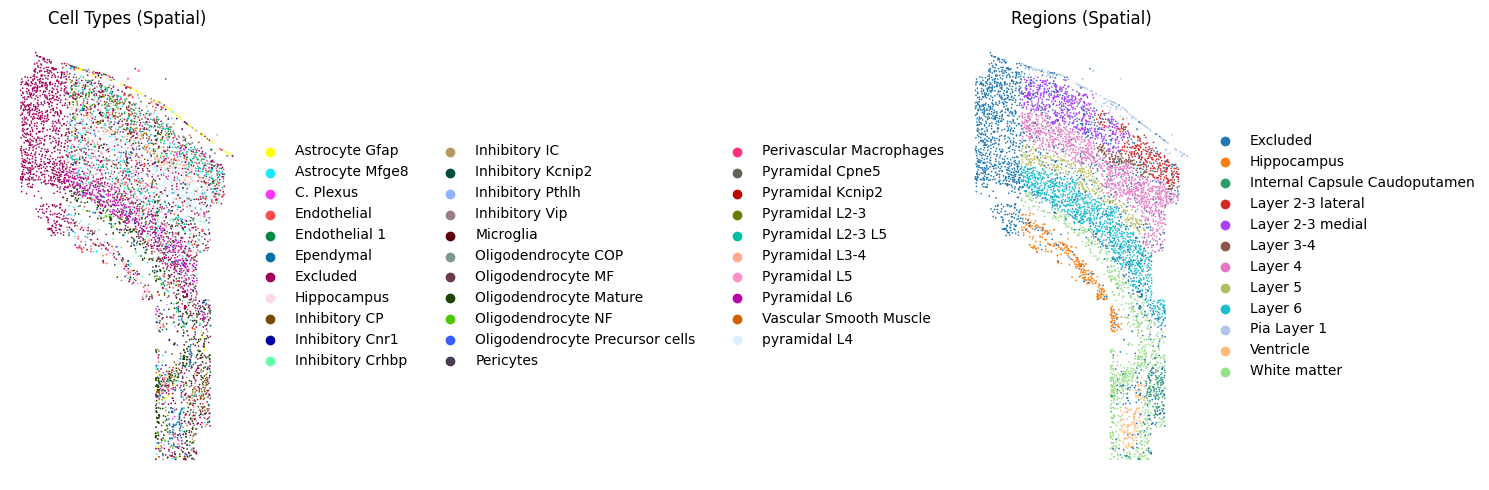


After filtering:  (6471, 33)
Using all genes for analysis


d:\Anaconda\envs\GraphSTenv\lib\site-packages\scanpy\preprocessing\_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [33]:
# 查看真实标签的分布
print("\n真实类别分布:")
print(adata.obs['ClusterName'].value_counts())

# 查看区域分布
print("\n区域分布:")
print(adata.obs['Region'].value_counts())

# 分析空间坐标的分布
coords = adata.obsm['spatial']
print("\n空间坐标范围:")
print("X range:", coords[:,0].min(), "-", coords[:,0].max())
print("Y range:", coords[:,1].min(), "-", coords[:,1].max())

# 计算细胞间的典型距离
from scipy.spatial.distance import pdist
sample_size = min(1000, len(adata))
indices = np.random.choice(len(adata), sample_size, replace=False)
sample_coords = coords[indices]
distances = pdist(sample_coords)
print("\n细胞间距的统计信息：")
print("最小距离:", np.min(distances))
print("25分位距离:", np.percentile(distances, 25))
print("中位距离:", np.median(distances))
print("平均距离:", np.mean(distances))

# 可视化原始数据
plt.rcParams["figure.figsize"] = (15, 5)
fig, (ax1, ax2) = plt.subplots(1, 2)

# 空间分布 - 按真实类型
sc.pl.embedding(adata, basis="spatial", color="ClusterName", 
                s=6, show=False, title='Cell Types (Spatial)',
                ax=ax1)
ax1.axis('off')

# 空间分布 - 按区域
sc.pl.embedding(adata, basis="spatial", color="Region", 
                s=6, show=False, title='Regions (Spatial)',
                ax=ax2)
ax2.axis('off')

plt.tight_layout()
plt.show()

# 开始STAGATE分析
# 1. 预处理
adata.raw = adata

# 基本过滤
sc.pp.filter_genes(adata, min_cells=50)
print('\nAfter filtering: ', adata.shape)

# 标准化
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# 由于基因数较少(33个)，我们不需要选择高变基因
print('Using all genes for analysis')

In [34]:
# 2. 设置GraphST参数
# 从真实标签类别数确定聚类数
n_clusters = len(adata.obs['ClusterName'].unique())
print(f"\n真实标签类别数: {n_clusters}")


真实标签类别数: 32


In [35]:
model = GraphST_SVG(adata, random_seed=1, device=device)
adata = model.train()

Identifying variable genes using scanpy...
Number of identified variable genes: 33


d:\Anaconda\envs\GraphSTenv\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Begin to train ST data...


100%|██████████| 600/600 [00:05<00:00, 103.08it/s]

Optimization finished for ST data!


In [32]:
# 3. 运行不带HVG筛选的GraphST
print("\nRunning GraphST without HVG filtering...")
model = GraphST_NoHVG(adata, random_seed=1, device=device)
adata = model.train()


Running GraphST without HVG filtering...
Begin to train ST data...


100%|██████████| 600/600 [00:05<00:00, 106.97it/s]

Optimization finished for ST data!


In [160]:
model = GraphST.GraphST(
    adata,
    random_seed=1,
    device=device
)

d:\Anaconda\envs\GraphSTenv\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
d:\Anaconda\envs\GraphSTenv\lib\site-packages\scanpy\preprocessing\_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [161]:
adata = model.train()

Begin to train ST data...


100%|██████████| 600/600 [00:05<00:00, 103.36it/s]

Optimization finished for ST data!


fitting ...
  |======================================================================| 100%


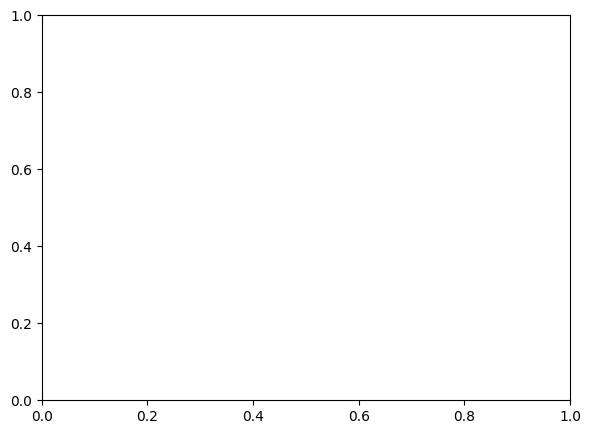

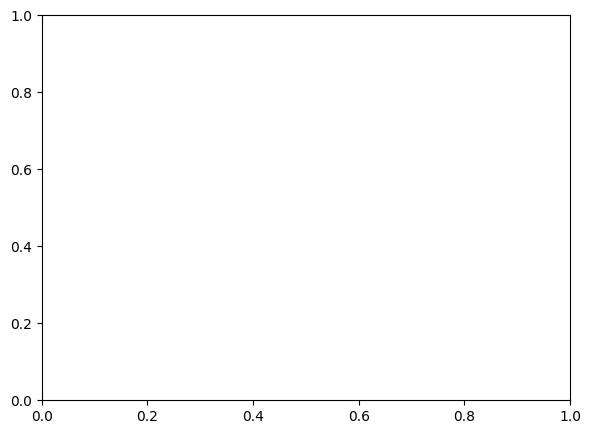

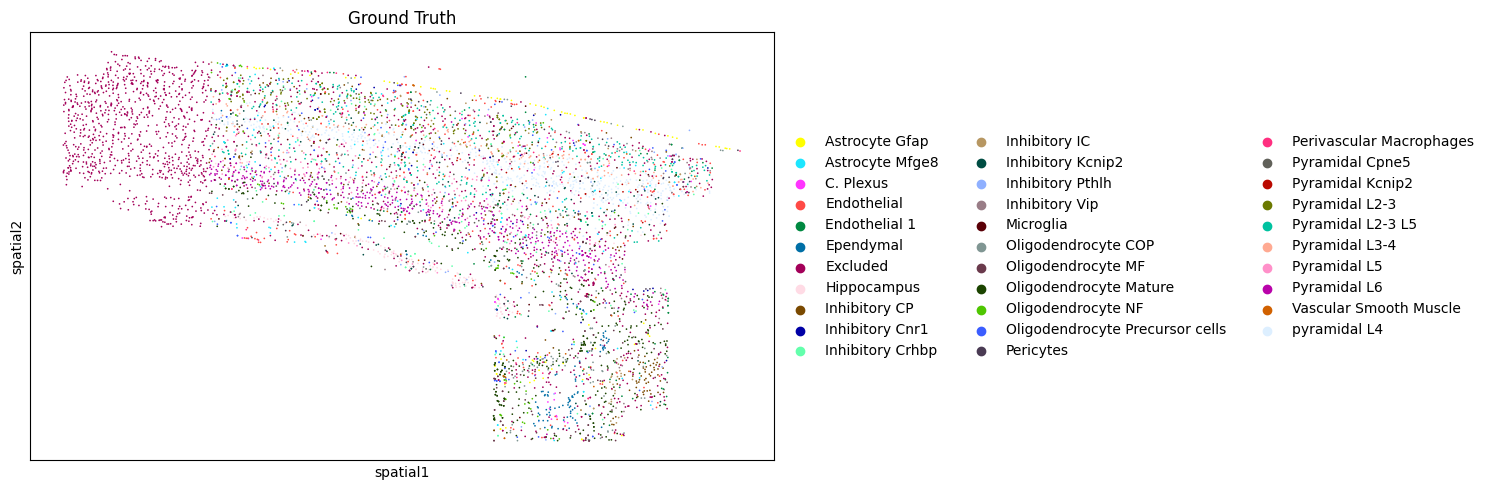

In [36]:
clustering(adata, n_clusters=n_clusters, method='mclust')

# 创建对比图
plt.figure(figsize=(15, 5))

# 预测结果
plt.subplot(121)
sc.pl.embedding(adata, basis="spatial", color="domain",
                s=10, title='GraphST Clusters',
                show=False)

# 真实标签
plt.subplot(122)
sc.pl.embedding(adata, basis="spatial", color="ClusterName",
                s=6, title='Ground Truth',
                show=False)

plt.tight_layout()
plt.show()

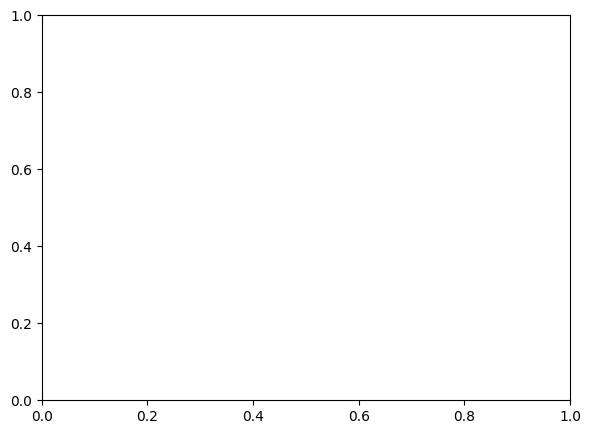

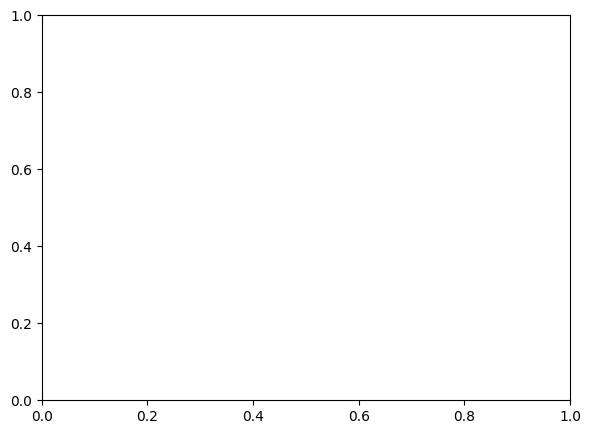

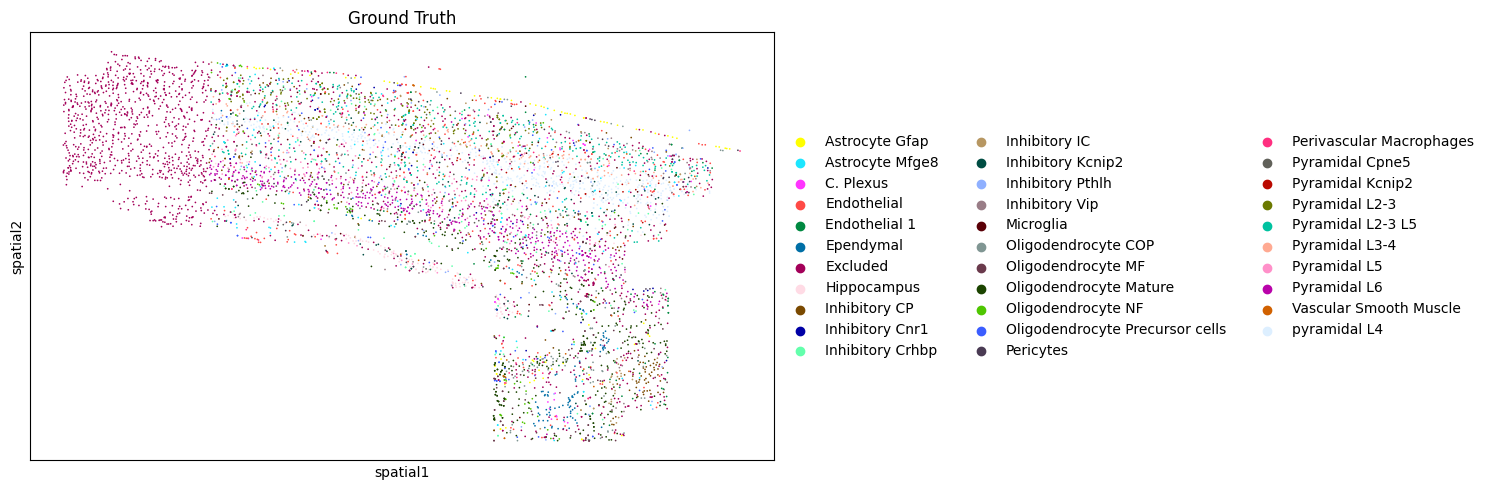

In [37]:
# 创建对比图
plt.figure(figsize=(15, 5))

# 预测结果
plt.subplot(121)
sc.pl.embedding(adata, basis="spatial", color="domain",
                s=10, title='GraphST Clusters',
                show=False)

# 真实标签
plt.subplot(122)
sc.pl.embedding(adata, basis="spatial", color="ClusterName",
                s=6, title='Ground Truth',
                show=False)

plt.tight_layout()
plt.show()

In [38]:
# 检查空间坐标
print("Spatial coordinates shape:", adata.obsm['spatial'].shape)
print("Spatial coordinates range:")
print("X range:", adata.obsm['spatial'][:, 0].min(), "-", adata.obsm['spatial'][:, 0].max())
print("Y range:", adata.obsm['spatial'][:, 1].min(), "-", adata.obsm['spatial'][:, 1].max())

Spatial coordinates shape: (6471, 2)
Spatial coordinates range:
X range: -6565.45475168401 - 23895.58588501429
Y range: 0.0 - 49626.243832344764


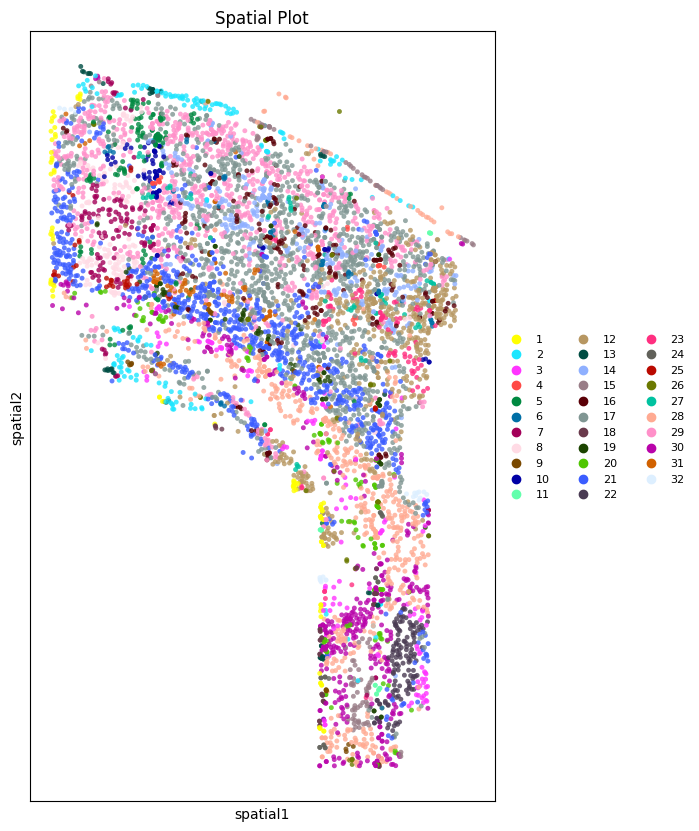

In [39]:
fig, ax = plt.subplots(figsize=(6, 10))
sc.pl.embedding(adata, 
                basis="spatial", 
                color="domain",  # 或者 "domain" 如果要看聚类结果
                ax = ax,
                s=50,  # 增大点的大小
                alpha=0.8,  # 设置透明度
                title='Spatial Plot',
                legend_loc='right margin',
                legend_fontsize=8)
plt.show()

In [40]:
def evaluate_graphst_results(adata, pred_key='domain', truth_key='ClusterName', spatial_key='spatial'):
    """评估GraphST聚类结果的综合函数，专门针对osmFISH数据集"""
    
    # 首先移除标记为'Excluded'的细胞
    mask = adata.obs[truth_key] != 'Excluded'
    
    # 获取预测标签和真实标签（排除Excluded细胞）
    pred_labels = adata.obs[pred_key][mask]
    true_labels = adata.obs[truth_key][mask]
    
    print("\n=== 数据统计 ===")
    print(f"总细胞数: {len(adata)}")
    print(f"排除Excluded后的细胞数: {sum(mask)}")
    print(f"预测的类别数: {len(np.unique(pred_labels))}")
    print(f"真实的类别数（不含Excluded）: {len(np.unique(true_labels))}")
    
    # 计算基本指标
    hom = homogeneity_score(true_labels, pred_labels)
    com = completeness_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    
    # 计算空间相关指标（使用所有细胞，包括Excluded）
    chaos = calculate_chaos_score(adata, pred_key, spatial_key)
    pas = calculate_pattern_score(adata, pred_key, spatial_key)
    asw = calculate_spatial_asw(adata, pred_key, spatial_key)
    
    # 打印所有评估指标
    print("\n=== GraphST聚类评估结果 ===")
    print(f"同质性分数 (HOM) = {hom:.4f}")
    print(f"完整性分数 (COM) = {com:.4f}")
    print(f"调整兰德指数 (ARI) = {ari:.4f}")
    print(f"标准化互信息 (NMI) = {nmi:.4f}")
    print(f"空间混乱度 (CHAOS) = {chaos:.4f} (越小越好)")
    print(f"空间模式分数 (PAS) = {pas:.4f} (越大越好)")
    print(f"空间轮廓系数 (ASW) = {asw:.4f} (越大越好)")
    
    # 打印每个类别的评估结果
    print("\n=== 各类别统计 ===")
    cluster_stats = pd.DataFrame({
        'True_Count': adata.obs[truth_key][mask].value_counts(),
        'Pred_Count': adata.obs[pred_key][mask].value_counts()
    })
    print(cluster_stats)
    
    # 返回所有指标的字典
    return {
        'HOM': hom,
        'COM': com,
        'ARI': ari,
        'NMI': nmi,
        'CHAOS': chaos,
        'PAS': pas,
        'ASW': asw
    }

In [41]:
metrics = evaluate_graphst_results(adata)


=== 数据统计 ===
总细胞数: 6471
排除Excluded后的细胞数: 4839
预测的类别数: 32
真实的类别数（不含Excluded）: 31

=== GraphST聚类评估结果 ===
同质性分数 (HOM) = 0.2105
完整性分数 (COM) = 0.2389
调整兰德指数 (ARI) = 0.0758
标准化互信息 (NMI) = 0.2238
空间混乱度 (CHAOS) = 0.6980 (越小越好)
空间模式分数 (PAS) = 0.5418 (越大越好)
空间轮廓系数 (ASW) = 0.3350 (越大越好)

=== 各类别统计 ===
                        True_Count  Pred_Count
1                              NaN        49.0
2                              NaN       106.0
3                              NaN       113.0
4                              NaN        20.0
5                              NaN        62.0
...                            ...         ...
Pyramidal L3-4               158.0         NaN
Pyramidal L5                 171.0         NaN
Pyramidal L6                 439.0         NaN
Vascular Smooth Muscle        37.0         NaN
pyramidal L4                 526.0         NaN

[64 rows x 2 columns]
